# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, March 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius <christopher.lucasius@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://drive.google.com/file/d/1VmsdFq2bKZoESfT4Ny8WHn4trNtf8g5l/view?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [ ]:
traits = ["age", "yredu", "capgain", "caploss", "workhr"]
for trait in traits:
    col = subdf[trait]
    print(trait)
    print(col.max())
    print(col.min())
    print(col.mean())

    col = col - col.min()
    col = col / col.max()
    df[trait] = col

df.describe()



age
90
17
38.58164675532078
yredu
16
1
10.0806793403151
capgain
99999
0
1077.6488437087312
caploss
4356
0
87.303829734959
workhr
99
1
40.437455852092995


,age,fnlwgt,yredu,capgain,caploss,workhr
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.295639,1.897784e+05,0.605379,0.010777,0.020042,0.402423
std,0.186855,1.055500e+05,0.171515,0.073854,0.092507,0.125994
min,0.000000,1.228500e+04,0.000000,0.000000,0.000000,0.000000
25%,0.150685,1.178270e+05,0.533333,0.000000,0.000000,0.397959
50%,0.273973,1.783560e+05,0.600000,0.000000,0.000000,0.397959
75%,0.424658,2.370510e+05,0.733333,0.000000,0.000000,0.448980
max,1.000000,1.484705e+06,1.000000,1.000000,1.000000,1.000000


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
male = sum(df["sex"] == " Male")
female = sum(df["sex"] == " Female")
print("male is", male, " percent, female is", female)

male is 21790  percent, female is 10771


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]
print("missing features: ", len(df_with_missing))
print("percentage of missing features: ", len(df_with_missing) / (len(df_with_missing) + len(df_not_missing)))

missing features:  1843
percentage of missing features:  0.056601455729246644


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
#print("there are", data.shape, "columns")
print(df_not_missing)

print(data)

            age     yredu   capgain  ...          edu    relationship      sex
0      0.301370  0.800000  0.021740  ...    Bachelors   Not-in-family     Male
1      0.452055  0.800000  0.000000  ...    Bachelors         Husband     Male
2      0.287671  0.533333  0.000000  ...      HS-grad   Not-in-family     Male
3      0.493151  0.400000  0.000000  ...         11th         Husband     Male
4      0.150685  0.800000  0.000000  ...    Bachelors            Wife   Female
...         ...       ...       ...  ...          ...             ...      ...
32556  0.136986  0.733333  0.000000  ...   Assoc-acdm            Wife   Female
32557  0.315068  0.533333  0.000000  ...      HS-grad         Husband     Male
32558  0.561644  0.533333  0.000000  ...      HS-grad       Unmarried   Female
32559  0.068493  0.533333  0.000000  ...      HS-grad       Own-child     Male
32560  0.479452  0.533333  0.150242  ...      HS-grad            Wife   Female

[30718 rows x 11 columns]
            age     yredu

ANS: There are several features in each feature type. For example, "edu" has features "bachelors", "HS-grad", and etc. Each feature needs one encoding. The sum of all features is 57, therefore the one-hot encoding has dimension of 57.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    index = np.argmax(onehot)
    return cat_values[feature][index]

In [ ]:
print(cat_index)

print(cat_values)

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [ ]:
get_categorical_value([0, 0, 0, 0, 0, 0, 0], "work")

'Federal-gov'

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo

brk1 = int(datanp.shape[0] * 0.7)
brk2 = int(datanp.shape[0] * 0.85)

#print(brk1)
train_set = datanp[:brk1]
val_set = datanp[brk1:brk2]
test_set = datanp[brk2:]

print("train set: ", train_set.shape[0])
print("val set: ", val_set.shape[0])
print("test set: ", test_set.shape[0])

train set:  21502
val set:  4608
test set:  4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 40), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(40, 30),
            nn.Linear(30, 20),
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 30),
            nn.Linear(30, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

Since the data was normalized, the produced output should also be reduced into a range of [0, 1].

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
import matplotlib.pyplot as plt

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))
    
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(net, criterion, loader):
    for data in loader:
        data_random = zero_out_random_feature(data.clone())
        predict = net(data_random)
        loss = criterion(predict, data)
    
    return loss.item() 

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4, batch_size = 32):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    iters = np.arange(num_epochs)
    for epoch in range(num_epochs):
        sum_loss = 0
        count = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            sum_loss += loss.item()
            count += 1
        sum_loss = sum_loss / count
        
        train_loss[epoch] = sum_loss
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_loss[epoch] = evaluate(model, criterion, valid_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)
        
        print(("Epoch {}: Train acc: {} , Train loss: {} |"+
                  "Validation acc: {}, Validation loss: {}").format(
                      epoch,
                      train_acc[epoch],
                      train_loss[epoch],
                      val_acc[epoch],
                      val_loss[epoch]))
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()



### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 0: Train acc: 0.4581511797352184 , Train loss: 0.1257274784369483 |Validation acc: 0.4576822916666667, Validation loss: 0.07116664201021194
Epoch 1: Train acc: 0.46494899699252784 , Train loss: 0.06955013943037816 |Validation acc: 0.4637586805555556, Validation loss: 0.06825968623161316
Epoch 2: Train acc: 0.5371515827984994 , Train loss: 0.05966066176603947 |Validation acc: 0.5351924189814815, Validation loss: 0.05483979359269142
Epoch 3: Train acc: 0.5561265618702136 , Train loss: 0.05268117685114876 |Validation acc: 0.5575810185185185, Validation loss: 0.05298236384987831
Epoch 4: Train acc: 0.5607772920348495 , Train loss: 0.04906060073768631 |Validation acc: 0.5631510416666666, Validation loss: 0.04602350294589996
Epoch 5: Train acc: 0.5622267696028277 , Train loss: 0.047372584824361616 |Validation acc: 0.5660807291666666, Validation loss: 0.047747429460287094
Epoch 6: Train acc: 0.571745264006449 , Train loss: 0.04539031607453667 |Validation acc: 0.5705656828703703, Validat

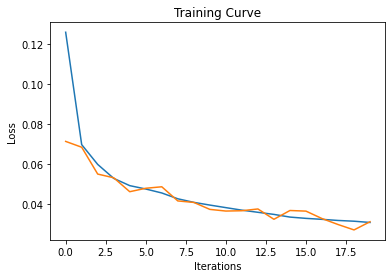

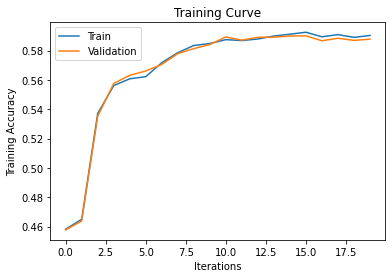

In [ ]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size= batch_size, shuffle = True)
# default
encoder = AutoEncoder()

train(encoder, train_loader, val_loader, num_epochs = 20, learning_rate=0.0001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

Epoch 0: Train acc: 0.577333891420953 , Train loss: 0.06183482715970881 |Validation acc: 0.5761357060185185, Validation loss: 0.04104549437761307
Epoch 1: Train acc: 0.5874182246612718 , Train loss: 0.035932654675672804 |Validation acc: 0.5879629629629629, Validation loss: 0.03130550682544708
Epoch 2: Train acc: 0.5960840852013766 , Train loss: 0.029871807076103454 |Validation acc: 0.5959201388888888, Validation loss: 0.025263013318181038
Epoch 3: Train acc: 0.5979133723994667 , Train loss: 0.026209899356001102 |Validation acc: 0.5943648726851852, Validation loss: 0.023332523182034492
Epoch 4: Train acc: 0.6014324248907078 , Train loss: 0.0239604970903158 |Validation acc: 0.6019241898148148, Validation loss: 0.0207435954362154
Epoch 5: Train acc: 0.5996651474281463 , Train loss: 0.022238192913521613 |Validation acc: 0.5970775462962963, Validation loss: 0.019542288035154343
Epoch 6: Train acc: 0.6125011626825412 , Train loss: 0.021045904297525772 |Validation acc: 0.6099537037037037, Val

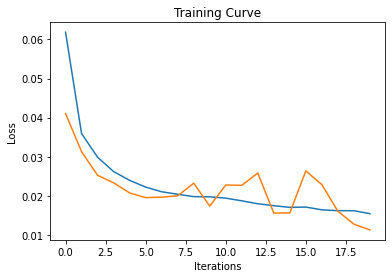

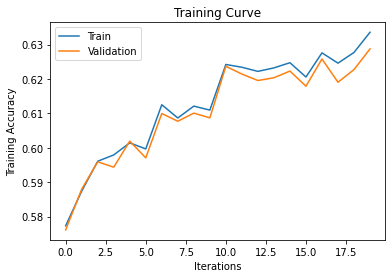

In [ ]:
# attempt 2, set learning_rate = 0.001
encoder2 = AutoEncoder()

train(encoder2, train_loader, val_loader, num_epochs = 20, learning_rate=0.001)

The training and validation loss seem to have the potential of going down further. Learning rate of 0.0001 is somewhat conservative, in the next step we in crease learning rate.

Epoch 0: Train acc: 0.5833643382010976 , Train loss: 0.03923556492442176 |Validation acc: 0.5819589120370371, Validation loss: 0.025898246094584465
Epoch 1: Train acc: 0.6139893963352246 , Train loss: 0.02399836507503919 |Validation acc: 0.6087962962962963, Validation loss: 0.02128646709024906
Epoch 2: Train acc: 0.6132685331597061 , Train loss: 0.020748646891055007 |Validation acc: 0.6106409143518519, Validation loss: 0.020420314744114876
Epoch 3: Train acc: 0.6275617771990203 , Train loss: 0.01964457442850939 |Validation acc: 0.6219979745370371, Validation loss: 0.01695571094751358
Epoch 4: Train acc: 0.6265386165628004 , Train loss: 0.018589564703731975 |Validation acc: 0.6193214699074074, Validation loss: 0.013787846080958843
Epoch 5: Train acc: 0.6220739156047499 , Train loss: 0.01788519406511027 |Validation acc: 0.6166811342592593, Validation loss: 0.015107560902833939
Epoch 6: Train acc: 0.6298948934982792 , Train loss: 0.017942618113011122 |Validation acc: 0.6244212962962963, V

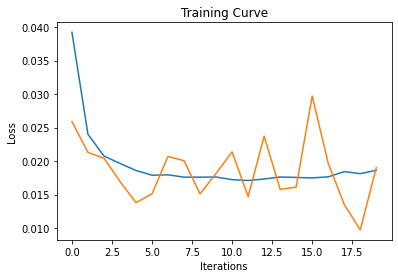

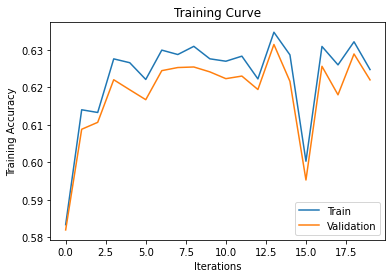

In [ ]:
# attempt 3, set learning_rate = 0.01
encoder3 = AutoEncoder()

train(encoder3, train_loader, val_loader, num_epochs = 20, learning_rate=0.01)

The training curve stablizes too quickly, while the validation curve is very unstable and does not exhibit a decreasing trend. These all signifies that the learning rate is way too large, we will decrease the learning rate to 0.005 in the next step.

Epoch 0: Train acc: 0.6044553994977211 , Train loss: 0.04274842350111742 |Validation acc: 0.6047815393518519, Validation loss: 0.03047829493880272
Epoch 1: Train acc: 0.6286624500046507 , Train loss: 0.023693202833999834 |Validation acc: 0.6257957175925926, Validation loss: 0.02540311962366104
Epoch 2: Train acc: 0.6283446501100672 , Train loss: 0.018858167007454626 |Validation acc: 0.6242766203703703, Validation loss: 0.023572875186800957
Epoch 3: Train acc: 0.631158341859672 , Train loss: 0.0169032003052832 |Validation acc: 0.6294126157407407, Validation loss: 0.015050210058689117
Epoch 4: Train acc: 0.6367004619725297 , Train loss: 0.015864920019382788 |Validation acc: 0.6317635995370371, Validation loss: 0.011996208690106869
Epoch 5: Train acc: 0.6424286112919728 , Train loss: 0.015267514444574425 |Validation acc: 0.6358506944444444, Validation loss: 0.015055919997394085
Epoch 6: Train acc: 0.6252751682014076 , Train loss: 0.014904409588087305 |Validation acc: 0.6216362847222222, V

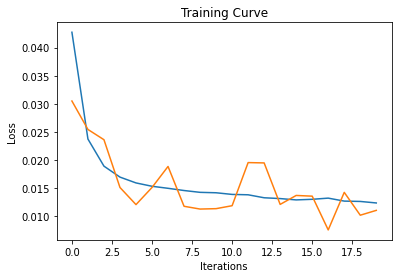

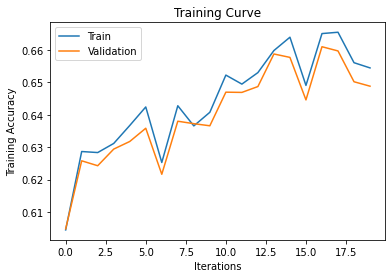

In [ ]:
# attempt 4, set learning_rate = 0.005
encoder4 = AutoEncoder()

train(encoder4, train_loader, val_loader, num_epochs = 20, learning_rate=0.005)

This is now much better! Not only does it give the models with highest training and validation accuracy so far, the training and validation loss curves also present that they outperformed the previous two models.

Next we will try the same learning rate, but increase batch size to 64.

Epoch 0: Train acc: 0.5920146963073203 , Train loss: 0.04272372922527471 |Validation acc: 0.5912905092592593, Validation loss: 0.027073711156845093
Epoch 1: Train acc: 0.6184773509440982 , Train loss: 0.023474645178620926 |Validation acc: 0.6150896990740741, Validation loss: 0.02547185681760311
Epoch 2: Train acc: 0.612741450407714 , Train loss: 0.019077824711400484 |Validation acc: 0.6092303240740741, Validation loss: 0.01709005981683731
Epoch 3: Train acc: 0.6207484575078287 , Train loss: 0.01721948659923371 |Validation acc: 0.6170428240740741, Validation loss: 0.015474575571715832
Epoch 4: Train acc: 0.6152295910457942 , Train loss: 0.016584054121354018 |Validation acc: 0.6142939814814815, Validation loss: 0.009579514153301716
Epoch 5: Train acc: 0.6237869345487241 , Train loss: 0.01597771113197918 |Validation acc: 0.6206597222222222, Validation loss: 0.018797166645526886
Epoch 6: Train acc: 0.6135940842712306 , Train loss: 0.015499462282778473 |Validation acc: 0.6102068865740741, V

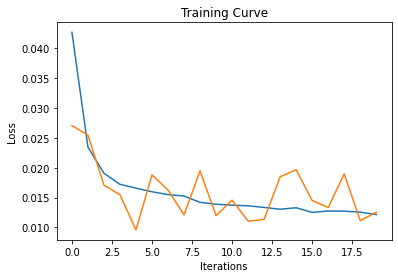

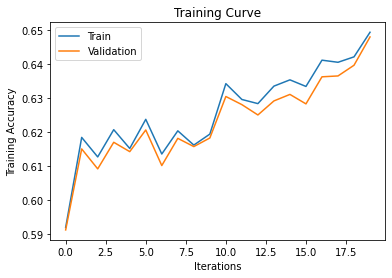

In [ ]:
# attempt 5, set learning_rate = 0.005, batch_size = 64
encoder5 = AutoEncoder()

train(encoder5, train_loader, val_loader, num_epochs = 20, learning_rate=0.005, batch_size=64)

Not bad, although the validation loss stablizes more quickly. Overall it is still not as good as Encoder4. Thus we will go straight with Encoder4.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader =  torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle= True)
get_accuracy(encoder4, test_loader)

0.6539351851851852

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
total_acc = 0

for feature in cat_index:
    total_acc += df_not_missing[feature].value_counts().max()
total_acc = total_acc / (df_not_missing.shape[0] * len(cat_index))
print(total_acc)

0.459204158256831


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy from part (a) is 0.654, outperforming the baseline accuracy by approximately 0.2, which has 0.459 accuracy.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
pd.DataFrame(data = test_set[0:5], columns = data.columns)

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.369863,0.800000,0.0,0.0,0.448980,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.095890,0.533333,0.0,0.0,0.602041,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.232877,0.533333,0.0,0.0,0.602041,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.400000,0.0,0.0,0.112245,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.602740,0.866667,0.0,0.0,0.448980,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


ANS: To some extent, Yes. One can tell the education level of a person based on the feature "yredu". For example, it is reasonable to assume the education level of the 1st and 4th item to be higher than the remaining 3, because their "yredu" are among the highest; the truth is that the 1st has a bachlors degree and the 4th has a masters degree.

The problem is that there are many other features such as marital status that are not necessarily directly correlated with education level; in fact, it is even hard to determine whether the two features are related. On the other hand, two people with identical feature labels may have completely different education levels.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
person = [test_set[0]]
person_loader = torch.utils.data.DataLoader(person)

for item in person_loader:
    output = encoder4(zero_out_feature(item.clone(), 'edu')).detach().numpy()
    print(get_feature(output[0], 'edu'))



Bachelors


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
prd = df_not_missing['edu'].value_counts().idxmax()
print(prd)

 HS-grad
